# Citywide Cellular Traffic Prediction Based on Densely Connected Convolutional Neural Networks
## —— Model Structure & Train

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch import optim
import torch.utils.data as torchData
import torch.nn.functional as F
from collections import OrderedDict

Parameters

In [2]:
sizeClose  = 3
sizePeriod = 3
sizeTrend  = 0

learningRate = 0.001
batchSize = 16
epochSize = 300
dropRate = 0.0

nb_flow = 1

channels = [sizeClose  * nb_flow,
            sizePeriod * nb_flow,
            sizeTrend  * nb_flow]

### Dataset Input

In [3]:
xTrain = np.load('xTrain.npy')
yTrain = np.load('yTrain.npy')
xTest = np.load('xTest.npy')
yTest = np.load('yTest.npy')

In [4]:
print(xTrain.shape)
print(yTrain.shape)

(480, 2, 3, 100, 100)
(480, 1, 100, 100)


In [5]:
xTrain2 = torch.from_numpy(xTrain).float()
yTrain2 = torch.from_numpy(yTrain).float()
xTest2  = torch.from_numpy(xTest).float()
yTest2  = torch.from_numpy(yTest).float()

loaderTrain = torchData.DataLoader(
    torchData.TensorDataset(xTrain2, yTrain2), 
    batch_size=batchSize, num_workers=8, pin_memory=True
)

loaderTest = torchData.DataLoader(
    torchData.TensorDataset(xTest2, yTest2),
    batch_size=batchSize, shuffle=False
)

## Model Structure

Dense Networks

In [6]:
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(
            num_input_features, bn_size * growth_rate,
            kernel_size=1, stride=1, bias=False
        ))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(
            bn_size * growth_rate, growth_rate,
            kernel_size=3, stride=1, padding=1, bias=False
        ))
        self.drop_rate = drop_rate

    def forward(self, input):
        new_features = super(_DenseLayer, self).forward(input)
        if self.drop_rate > 0:
            new_features = F.dropout(
                new_features, p=self.drop_rate,
                training=self.training
            )
        return torch.cat([input, new_features], 1)

In [7]:
class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

In [8]:
class DenseNetUnit(nn.Sequential):
    def __init__(
        self, channels, nb_flows, layers=5, growth_rate=12,
        num_init_features=32, bn_size=4, drop_rate=0.2
    ):
        super().__init__()

        if channels > 0:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(channels, num_init_features, kernel_size=3, padding=1)),
                ('norm0', nn.BatchNorm2d(num_init_features)),
                ('relu0', nn.ReLU(inplace=True))
            ]))

            # Dense Block
            num_features = num_init_features
            num_layers = layers
            block = _DenseBlock(
                num_layers=num_layers, num_input_features=num_features,
                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate
            )
            self.features.add_module('denseblock', block)
            num_features = num_features + num_layers * growth_rate

            # Final batch norm
            self.features.add_module('normlast', nn.BatchNorm2d(num_features))
            self.features.add_module('convlast', nn.Conv2d(
                num_features, nb_flows,
                kernel_size=1, padding=0, bias=False
            ))

            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight.data)
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    m.bias.data.zero_()
        else:
            pass

    def forward(self, x):
        out = self.features(x)
        return out

In [9]:
class DenseNet(nn.Module):
    def __init__(self, nb_flows, drop_rate, channels):
        super().__init__()
        self.drop_rate = drop_rate
        self.nb_flows = nb_flows
        self.channels = channels

        self.close_feature  = DenseNetUnit(channels[0], nb_flows)
        self.period_feature = DenseNetUnit(channels[1], nb_flows)
        self.trend_feature  = DenseNetUnit(channels[2], nb_flows)

    def forward(self, inputs):
        out = 0
        if self.channels[0] > 0:
            out += self.close_feature(inputs[:,0])
        if self.channels[1] > 0:
            out += self.period_feature(inputs[:,1])
        if self.channels[2] > 0:
            out += self.trend_feature(inputs[:,2])

        return torch.sigmoid(out)

## Model Train & Test

### Train

In [10]:
def set_lr(optimizer, epoch, n_epochs, lr):
    lr = lr
    if float(epoch) / n_epochs > 0.75:
        lr = lr * 0.01
    if float(epoch) / n_epochs > 0.5:
        lr = lr * 0.1

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

In [11]:
model = DenseNet(
    nb_flows = nb_flow, drop_rate = dropRate, channels = channels
).cuda()

optimizer = optim.Adam(model.parameters(), learningRate)
loss_func = nn.MSELoss().cuda()

lossTestBest = 1.0
lossTrain, lossTest = np.zeros(epochSize), np.zeros(epochSize)

for epoch in range(epochSize):
    # Train
    for step, (b_x, b_y) in enumerate(loaderTrain):
        b_x, b_y = b_x.cuda(), b_y.cuda()
        output = model(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossTrain[epoch] += loss.cpu() * batchSize
        
    lossTrain[epoch] = lossTrain[epoch] / len(xTrain2)

    # Test
    for step, (b_x, b_y) in enumerate(loaderTest):
        b_x, b_y = b_x.cuda(), b_y.cuda()
        output = model(b_x)
        lossTest[epoch] += loss_func(output, b_y) * batchSize
        
    lossTest[epoch] = lossTest[epoch] / len(xTest2)

    # Analyse
    if lossTest[epoch] < lossTestBest:
        lossTestBest = lossTest[epoch]
        torch.save(model, '202207160300.pkl')
        
    print((
        'iter: [{:d}/{:d}], lossTrain: {:0.6f}, lossTest: {:0.6f}, '
        'loss Test Best: {:0.6f}, lr: {:0.5f}'
    ).format(
        (epoch + 1), epochSize, lossTrain[epoch], lossTest[epoch], lossTestBest, learningRate
    ))


iter: [1/300], lossTrain: 0.121696, lossTest: 0.083794, loss Test Best: 0.083794, lr: 0.00100
iter: [2/300], lossTrain: 0.061666, lossTest: 0.047189, loss Test Best: 0.047189, lr: 0.00100
iter: [3/300], lossTrain: 0.035008, lossTest: 0.026261, loss Test Best: 0.026261, lr: 0.00100
iter: [4/300], lossTrain: 0.020513, lossTest: 0.015504, loss Test Best: 0.015504, lr: 0.00100
iter: [5/300], lossTrain: 0.012420, lossTest: 0.009216, loss Test Best: 0.009216, lr: 0.00100
iter: [6/300], lossTrain: 0.007844, lossTest: 0.005920, loss Test Best: 0.005920, lr: 0.00100
iter: [7/300], lossTrain: 0.005314, lossTest: 0.004340, loss Test Best: 0.004340, lr: 0.00100
iter: [8/300], lossTrain: 0.003550, lossTest: 0.002522, loss Test Best: 0.002522, lr: 0.00100
iter: [9/300], lossTrain: 0.001759, lossTest: 0.001134, loss Test Best: 0.001134, lr: 0.00100
iter: [10/300], lossTrain: 0.000838, lossTest: 0.000639, loss Test Best: 0.000639, lr: 0.00100
iter: [11/300], lossTrain: 0.000531, lossTest: 0.000466, lo

iter: [88/300], lossTrain: 0.000073, lossTest: 0.000074, loss Test Best: 0.000074, lr: 0.00100
iter: [89/300], lossTrain: 0.000073, lossTest: 0.000074, loss Test Best: 0.000074, lr: 0.00100
iter: [90/300], lossTrain: 0.000073, lossTest: 0.000073, loss Test Best: 0.000073, lr: 0.00100
iter: [91/300], lossTrain: 0.000073, lossTest: 0.000074, loss Test Best: 0.000073, lr: 0.00100
iter: [92/300], lossTrain: 0.000073, lossTest: 0.000075, loss Test Best: 0.000073, lr: 0.00100
iter: [93/300], lossTrain: 0.000072, lossTest: 0.000073, loss Test Best: 0.000073, lr: 0.00100
iter: [94/300], lossTrain: 0.000072, lossTest: 0.000073, loss Test Best: 0.000073, lr: 0.00100
iter: [95/300], lossTrain: 0.000072, lossTest: 0.000073, loss Test Best: 0.000073, lr: 0.00100
iter: [96/300], lossTrain: 0.000072, lossTest: 0.000073, loss Test Best: 0.000073, lr: 0.00100
iter: [97/300], lossTrain: 0.000072, lossTest: 0.000073, loss Test Best: 0.000073, lr: 0.00100
iter: [98/300], lossTrain: 0.000072, lossTest: 0.0

KeyboardInterrupt: 

Show Result

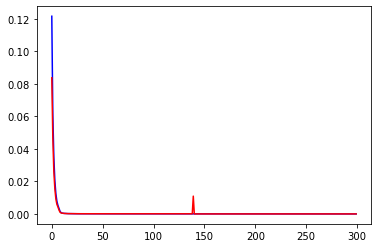

In [12]:
plt.plot(lossTrain, 'b')
plt.plot(lossTest, 'r')

In [18]:
model = torch.load('202207160300.pkl')

(16, 1, 100, 100)


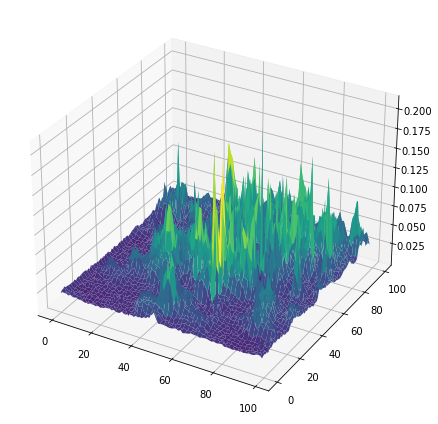

In [35]:
fig = plt.figure(figsize = (8.5, 6))

for step, (b_x, b_y) in enumerate(loaderTrain):
    b_x, b_y = b_x.cuda(), b_y.cuda()
    output = model(b_x).cpu().detach().numpy()
    print(output.shape)
    
    [X, Y] = np.meshgrid(np.arange(100), np.arange(100))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, output.sum(0).sum(0),cmap='viridis', edgecolor='none')
    break
    
fig.tight_layout()

tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<MulBack

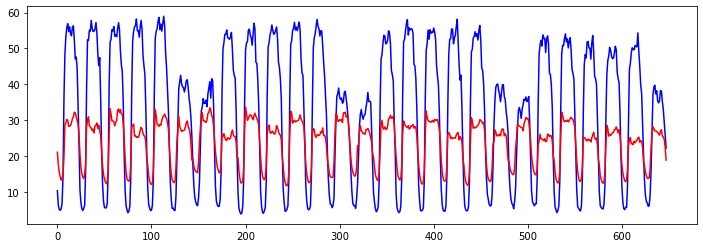

In [45]:
ans = np.zeros(24 * 27)
cur = 0

for step, (b_x, b_y) in enumerate(loaderTrain):
    b_x, b_y = b_x.cuda(), b_y.cuda()
    output = model(b_x)
    print(loss_func(output, b_y) * batchSize)
    output = output.cpu().detach().numpy().sum(2).sum(2).sum(1)

    for i in range(np.size(output)):
        ans[cur] = output[i]
        cur += 1

for step, (b_x, b_y) in enumerate(loaderTest):
    b_x, b_y = b_x.cuda(), b_y.cuda()
    output = model(b_x).cpu().detach().numpy().sum(2).sum(2).sum(1)

    for i in range(np.size(output)):
        ans[cur] = output[i]
        cur += 1
        
ans2 = np.append(yTrain.sum(2).sum(2).sum(1), yTest.sum(2).sum(2).sum(1), axis = 0)

fig = plt.figure(figsize = (12, 4))
plt.plot(ans2, 'b')
plt.plot(ans, 'r')
